In [1]:
!pip install bs4
!pip install wordcloud

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
import csv
import nltk
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.stem import SnowballStemmer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from scipy import stats
from bs4 import BeautifulSoup 
import random
random.seed()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1. Data cleaning

Stopwords are common words that carry less important meaning than keywords and they do not add value to build sentiment analysis model so they should be removed. I add comments that start with the hash character to clarify code for each step.

## Defining data cleaning function

In [3]:
#use nltk's stopwords
stopwords.words('english')
stop_words = set(stopwords.words('english'))

In [4]:
def data_cleaning(text):
    tokenizer = RegexpTokenizer(r'\w+')
    #replace html character codes by an ASCII equivalent.
    text = BeautifulSoup(text, 'lxml').get_text()
    #remove all html tags and attributes (i.e., /<[^>]+>/) 
    pattern_1 = r'<[^>]+>'
    #remove all URLs
    pattern_2 = r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b'
    combined_pattern = r'|'.join((pattern_1,pattern_2))
    new_text = re.sub(combined_pattern,'', text, flags=re.MULTILINE)
    #lowercasing
    new_text = new_text.lower()
    #turn text into some tokens and RegexTokenizer class extracts words and ignores whitespace and punctuation
    words = tokenizer.tokenize(new_text)
    #remove stopwords
    new_words = [word for word in words if word not in stop_words]
    return (" ".join(new_words)).strip()

## Calling the data cleaning function and saving cleaned data as Dataframe


I only select the "text" column and the "sentiment" column that I need for the sentiment analysis and build a Dataframe be brief and to the point. Other columns like "id","date","query" and "user" do not add value to build sentiment analysis model.

In [5]:
def clean_df(df):
    data_cleaning_texts = []
    for t in df.text:
        data_cleaning_texts.append(data_cleaning(t))
    clean_df = pd.DataFrame(data_cleaning_texts,columns=['text'])
    return clean_df 

In [6]:
generic_tweets_df = pd.read_csv('generic_tweets.txt',encoding='utf-8')
clean_generic_df = clean_df(generic_tweets_df)
clean_generic_df['sentiment'] = generic_tweets_df['class']
clean_generic_df.head()

,text,sentiment
0,switchfoot awww bummer shoulda got david carr ...,0
1,upset update facebook texting might cry result...,0
2,kenichan dived many times ball managed save 50...,0
3,whole body feels itchy like fire,0
4,nationwideclass behaving mad see,0


In [7]:
US_airline_tweets_df = pd.read_csv('US_airline_tweets.csv',encoding='utf-8')
clean_airline_df = clean_df(US_airline_tweets_df)
clean_airline_df['sentiment'] = US_airline_tweets_df['sentiment']
clean_airline_df.head()

,text,sentiment
0,virginamerica plus added commercials experienc...,positive
1,virginamerica really aggressive blast obnoxiou...,negative
2,virginamerica really big bad thing,negative
3,virginamerica seriously would pay 30 flight se...,negative
4,virginamerica yes nearly every time fly vx â œ...,positive


# 2. Exploratory analysis

## determine the airline of given tweets

I use regular expression matching operations to find the first @mention in each tweets since I find out the first @mention refers to the airline of a given tweet. It is true that more than one airline are mentioned in a few tweets but only the first mentioned airline corresponds to the sentiment (positive or negative).

First, I calculate frequency of occurences of each airline in all tweets. Then I calculate airline count in tweets of which the sentiment is "negative" and tweets of which the sentiment is "positive" respectively to get the distribution of the US airline of the tweets.

In [8]:
def determine_the_airline(df):
    airline_list = []
    for text in df.text:
        #use regular expression matching operations
        airline = re.search(re.compile(r'@[A-Za-z0-9]+'),text).group()
        #use lower() method to avoid different treatments on  "Usairways" and "usairways"
        airline_list.append(airline.lower())
    #calculate airline count
    airline_counter = Counter(airline_list)
    return airline_counter

In [9]:
#for all tweets
airline_count = determine_the_airline(US_airline_tweets_df)
airline_count.most_common(6)

[('@united', 3121),
 ('@usairways', 2525),
 ('@americanair', 2293),
 ('@southwestair', 1755),
 ('@jetblue', 1494),
 ('@virginamerica', 333)]

In [10]:
#for tweets of which the sentiment is "negative"
negative_tweets = US_airline_tweets_df[US_airline_tweets_df.sentiment == 'negative']
neg_airline_count = determine_the_airline(negative_tweets)
neg_airline_count.most_common(6)

[('@united', 2630),
 ('@usairways', 2256),
 ('@americanair', 1957),
 ('@southwestair', 1186),
 ('@jetblue', 952),
 ('@virginamerica', 181)]

In [11]:
#for tweets of which the sentiment is "positive"
positive_tweets = US_airline_tweets_df[US_airline_tweets_df.sentiment == 'positive']
pos_airline_count = determine_the_airline(positive_tweets)
pos_airline_count.most_common(6)

[('@southwestair', 569),
 ('@jetblue', 542),
 ('@united', 491),
 ('@americanair', 336),
 ('@usairways', 269),
 ('@virginamerica', 152)]

The airline counts are shown in the above outputs. Then I calculate the ratio of each airline counts to the sum of all airlines counts. Later I will present some figures to visualize the ratio.

As we can see in the following outputs, the United Airlines is mentioned most frequently of which the ratio is about 0.27 while VirginAmerica is mentioned less of which the ratio is about 0.03. The number of times these airlines that are mentioned are sorted in descending order:United,Usairways,Americanair,Southwestair, Jetblue,Virginamerica.

In [12]:
#for all tweets
airline_list = ['@united','@usairways','@americanair','@southwestair', '@jetblue','@virginamerica']
airline_sum = sum(list(map(lambda x: airline_count[x],airline_list)))
ratio = list(map(lambda x: airline_count[x]/airline_sum, airline_list))
ratio

[0.2708966235569829,
 0.21916500303793074,
 0.19902786216474264,
 0.15233052686398751,
 0.1296762433816509,
 0.028903740994705322]

What about ratio of each airline counts to the sum of all airlines counts when I only take negative tweets into account? As we can see in the following outputs, the United Airlines is still mentioned most frequently  while VirginAmerica still comes up less. The number of times these airlines that are mentioned are sorted in the same order as before.

In [13]:
#for tweets of which the sentiment is "negative"
neg_airline_sum = sum(list(map(lambda x: neg_airline_count[x],airline_list)))
neg_ratio = list(map(lambda x: neg_airline_count[x]/neg_airline_sum, airline_list))
neg_ratio

[0.2870552281161318,
 0.24623444662737393,
 0.21359965073128137,
 0.1294477188386815,
 0.1039074437895656,
 0.019755511896965727]

For tweets of which the sentiment is "postive", the number of times these airlines that are mentioned are sorted differently from the order before.

In [14]:
#for tweets of which the sentiment is "postive"
pos_airline_sum = sum(list(map(lambda x: pos_airline_count[x],airline_list)))
pos_ratio = list(map(lambda x: pos_airline_count[x]/pos_airline_sum, airline_list))
pos_ratio

[0.20813904196693514,
 0.11403136922424756,
 0.142433234421365,
 0.24120389995760916,
 0.2297583721916066,
 0.06443408223823655]

One airline company has many negative evaluation is probably because people often choose this company. I select another metric that is the ratio of the times that each airline are mentioned in negative tweets to that in positive tweets. The metric can somewhat present how each airline is viewed in the public eye. Higher values, lower satisfaction.

In [15]:
ratio = list(map(lambda x: neg_airline_count[x]/pos_airline_count[x], airline_list))
ratio

[5.356415478615071,
 8.386617100371748,
 5.824404761904762,
 2.0843585237258346,
 1.7564575645756457,
 1.1907894736842106]

## Presenting graphical figures 

For generic tweets, I use word cloud which are graphical representations of word frequency that give greater prominence to words that appear more frequently in generic tweets. I apply word cloud to tweets of which the sentiment is "negative" and "positive" respectively to show  what kind of words are frequent in tweets regarding two different sentiment.

It is true that word cloud method does not present much information and only presents word frequency. However, since I will choose word frequency as features of the logistic regression model, I would like to have a general idea what the features contain. What confuses me is that can a single neutral word like"today" which are big in the following figure makes sense for sentiment analysis? I think the single word should be put in the context which inspires me to use n_gram that is to use frequency of occurrences of combinations of adjacent words as features.

In [16]:
# get tweets of which the sentiment value is negative
neg_tweets = clean_generic_df[clean_generic_df.sentiment == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

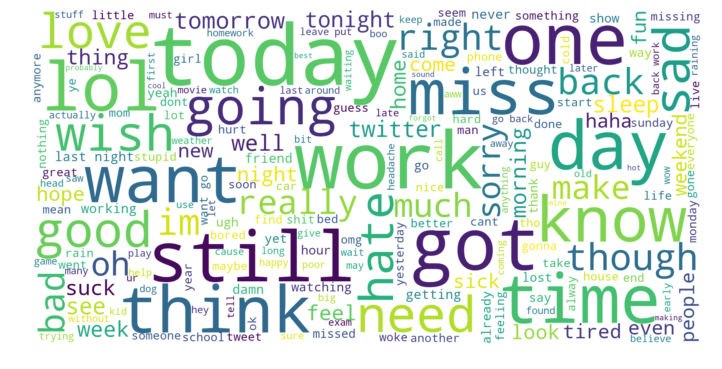

In [17]:
wordcloud = WordCloud(background_color="white",width=1600, height=800,max_font_size=200,random_state=42
).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [18]:
# get tweets of which the sentiment value is positive
pos_tweets = clean_generic_df[clean_generic_df.sentiment == 4]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

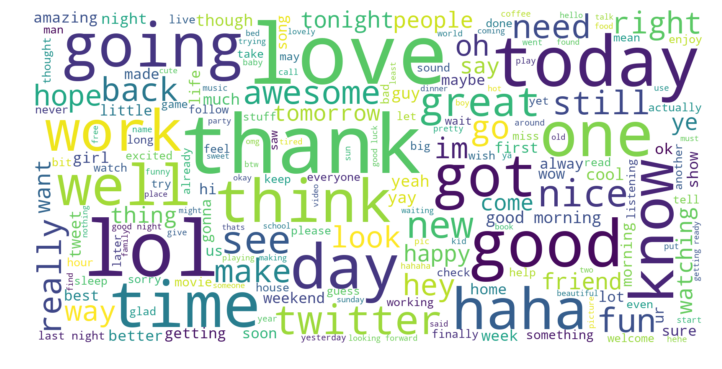

In [19]:

wordcloud = WordCloud(background_color="white",width=1600, height=800,max_font_size=200,random_state=42).generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

As I said before, I calculate the ratio of each airline counts to the sum of all airlines counts for "negative" tweets and "positive" tweets respectively. I present two figures to visualize the ratio.

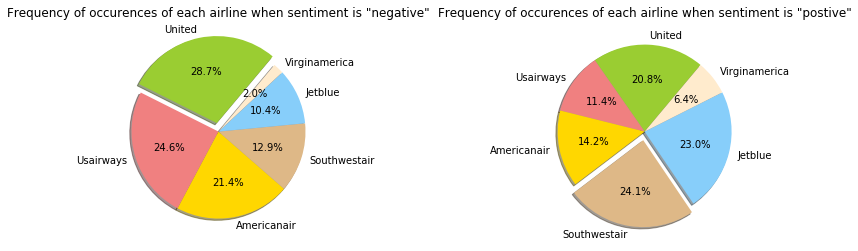

In [20]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1,2,1)
neg_airline_sum = sum(list(map(lambda x: neg_airline_count[x],airline_list)))
labels='United','Usairways','Americanair','Southwestair', 'Jetblue','Virginamerica'
sizes=list(map(lambda x: neg_airline_count[x]/neg_airline_sum, airline_list))
colors='yellowgreen','lightcoral','gold','burlywood','lightskyblue','blanchedalmond'
explode=(0.1,0,0,0,0,0)
ax.axis('equal')
p = ax.pie(sizes,explode=explode,labels=labels,colors=colors,autopct='%1.1f%%',shadow=True,startangle=50)
plt.title('Frequency of occurences of each airline when sentiment is "negative"',fontsize=12)

ax = fig.add_subplot(1,2,2)
pos_airline_sum = sum(list(map(lambda x: pos_airline_count[x],airline_list)))
sizes=list(map(lambda x: pos_airline_count[x]/pos_airline_sum, airline_list))
explode=(0,0,0,0.1,0,0)
ax.axis('equal')
p = ax.pie(sizes,explode=explode,labels=labels,colors=colors,autopct='%1.1f%%',shadow=True,startangle=50)
plt.title('Frequency of occurences of each airline when sentiment is "postive"',fontsize=12)
plt.show()

# 3. Model preparation


## TfidfVectorizer

At the beginning, I plan to use the frequency of each word as the features of the model. Later I find out that Scikit-learn provides TfidfVectorizer that converts a collection of raw documents to a matrix of TF-IDF features to extract features.

The tf-idf weight of a term is the product of its term frequency weight and its inverse document frequency weight. Raw term frequency is not what we want since relevance does not increase proportionally with term frequency. So log frequency weight or other variants are used instead in tf-idf. Idf weight is to dampen the effect of frequent terms that are less informative than rare terms.

All in all, I decide to use TfidfVectorizer to get a matrix of TF-IDF features.

In [21]:
def model_preparation(df):
    #feature selection
    vectorizer = TfidfVectorizer()
    #Convert a collection of raw documents to a matrix of TF-IDF features
    X = vectorizer.fit_transform(df['text'])
    #y is an array containning 0 or 4 that represent negative or positive
    y = df.sentiment
    return X,y,vectorizer

In [22]:
#get vectorizer to use the same vocabulary
X, y,vectorizer = model_preparation(clean_generic_df)

In [23]:
def model_preparation_2(df):
    #apply the vocabulary of generic_tweets to US_airline tweets 
    vectorizer2 = TfidfVectorizer(vocabulary=vectorizer.vocabulary_)
    X = vectorizer2.fit_transform(df['text'])
    rows_number = df.shape[0]
    y = [4 if df.sentiment[i] =='positive' else 0 for i in range(rows_number)]
    return X,y

In [24]:
X1, y1 = model_preparation_2(clean_airline_df)

# 4. Model implementation

Split the generic tweets randomly into training data (70%) and test data (30%)

In [25]:
#Split the generic tweets randomly into training data (70%) and test data (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression().fit(X_train, y_train)

# predict on test set
y_test_predict = clf.predict(X_test)

# calculate test accuracy
test_accuracy = accuracy_score(y_test, y_test_predict)
print("Test accuracy: {}".format(test_accuracy))

Test accuracy: 0.77015


In [26]:
# Evaluate the same model on the US airline data
y1_predict = clf.predict(X1)
US_airline_accuracy = accuracy_score(y1, y1_predict)

# report results
print("US_airline_accuracy: {}".format(US_airline_accuracy))

US_airline_accuracy: 0.7435230915865176


As we can see, the accuracy of the predictions of the sentiment of US_airline data is about 0.74. The accuracy is not very high so some methods are needed to improve the performance.


 ## Multi-class logistic regression
 
Split the negative US airline tweets into training data (70%) and test data (30%) and train a multi-class logistic regression model

For multiclass logistic regression, the default method is “ovr” which mean one versus rest and a binary problem is fit for each label. I use 'ovr' method to train a multi_class logistic regression model. I use TfidfVectorizer to get a matrix of TF-IDF features.


In [27]:
# select tweets of which the sentiment value is negative
neg_tweets = clean_airline_df[clean_airline_df.sentiment == 'negative']
neg = US_airline_tweets_df[US_airline_tweets_df.sentiment == 'negative']

In [28]:
def model_preparation_3(df):
    #feature selection
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df['text'])
    y = neg.negative_reason
    return X,y

In [29]:
X3,y3 = model_preparation_3(neg_tweets)

In [30]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42)

# train a logistic regression classifier
clf = LogisticRegression(C=1.0,solver='lbfgs',multi_class='ovr').fit(X3_train, y3_train)

# predict on test set
y3_test_predict = clf.predict(X3_test)

# calculate test accuracy
test_accuracy = accuracy_score(y3_test, y3_test_predict)

# report results
print("Test accuracy: {}".format(test_accuracy))

Test accuracy: 0.6053013798111837


# 5. Discussion

As we can see, the accuracy of the predictions of the sentiment of US_airline data is about 0.74. On the one hand, the result is satisfactory in a way   given that some mature commercialization programs have a correct rate of only 85% to 90% (such as BosonNLP). This shows that our simple model has indeed achieved satisfactory results. The key is to use the same vocalbulary when the matrix of TF-IDF features for both generic tweets and airline tweets are bulit. 

On the other hand, the way to select features, the way to extract features, the model and so on that are used in this assignment are just one way of many algorithms. Many changes can improve the baseline and the accuracy. For instance, we can use mutual information or Chi-square method to select features and eliminate noise features. Moreover, since the classifier uses the Bag of Words model, it assumes that each word is independent and it cannot be known that "not very good" is negative. There are many other classifiers like Naive Bayes classifier, SVM classifier, KNeighbors classifier and so on. We can also use nested cross validation to choose the best model and hyperparameters to get a better result.

When it comes to how each airline is viewed in the public eye based on the sentiment value, I use the prediction of the sentiment value of the airline tweets based on the first model. As we can see in the following figure, what is different from the ground truth labels is that the number of negative ratings of all airlines reduced and the number of positive ratings incresed based on predicted labels. 

In [31]:
'''
use the prediction of the sentiment value of the 
airline tweets based on the first model to calculate 
airline count in tweets of which the sentiment is "negative" 

'''
US_airline_tweets_df['class'] = y1
US_airline_tweets_df['predict_sentiment'] = y1_predict
negative_tweets = US_airline_tweets_df[US_airline_tweets_df.predict_sentiment == 0]
new_neg_airline_count = determine_the_airline(negative_tweets)
new_neg_airline_count.most_common(6)

[('@united', 1885),
 ('@usairways', 1679),
 ('@americanair', 1413),
 ('@southwestair', 948),
 ('@jetblue', 677),
 ('@virginamerica', 147)]

In [32]:
'''
use the prediction of the sentiment value of the 
airline tweets based on the first model to calculate 
airline count in tweets of which the sentiment is "positive" 

'''
positive_tweets = US_airline_tweets_df[US_airline_tweets_df.predict_sentiment == 4]
new_pos_airline_count = determine_the_airline(positive_tweets)
new_pos_airline_count.most_common(6)

[('@united', 1236),
 ('@americanair', 880),
 ('@usairways', 846),
 ('@jetblue', 817),
 ('@southwestair', 807),
 ('@virginamerica', 186)]

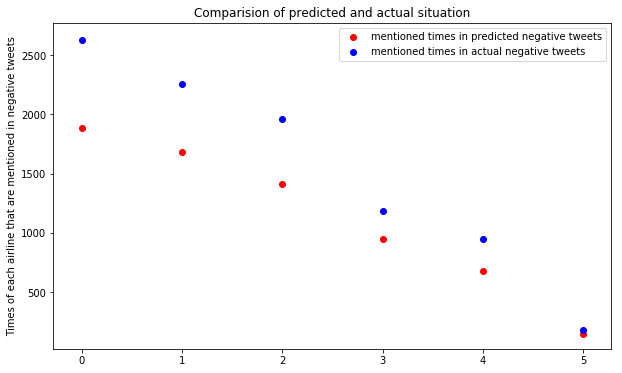

In [33]:
scale_ls = range(6)
index_ls = ('United','Usairways','Americanair','Southwestair', 'Jetblue','Virginamerica')
new_neg_count = list(map(lambda x: new_neg_airline_count[x], airline_list))
neg_count = list(map(lambda x: neg_airline_count[x], airline_list))
plt.figure(figsize=(10,6))
plt.scatter(scale_ls, new_neg_count, color='r', label='mentioned times in predicted negative tweets')
plt.scatter(scale_ls, neg_count, color='b', label='mentioned times in actual negative tweets')
plt.ylabel('Times of each airline that are mentioned in negative tweets')
plt.title('Comparision of predicted and actual situation')
plt.legend(loc='upper right')

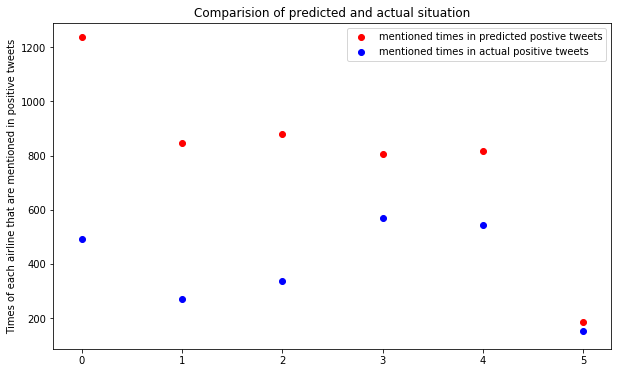

In [34]:
new_pos_count = list(map(lambda x: new_pos_airline_count[x], airline_list))
pos_count = list(map(lambda x: pos_airline_count[x], airline_list))
plt.figure(figsize=(10,6))
plt.scatter(scale_ls, new_pos_count, color='r', label='mentioned times in predicted postive tweets')
plt.scatter(scale_ls, pos_count, color='b', label='mentioned times in actual positive tweets')
plt.ylabel('Times of each airline that are mentioned in positive tweets')
plt.title('Comparision of predicted and actual situation')
plt.legend(loc='upper right')

And then I select the metric that is the ratio of the times that each airline are mentioned in negative tweets to that in positive tweets again. As I said before, the metric can somewhat present how each airline is viewed in the public eye. Higher values, lower satisfaction.

In [35]:
new_ratio = list(map(lambda x: new_neg_airline_count[x]/(new_pos_airline_count[x]), airline_list))
new_ratio

[1.5250809061488673,
 1.9846335697399526,
 1.6056818181818182,
 1.174721189591078,
 0.828641370869033,
 0.7903225806451613]

To find why some tweets for which the model failed to predict the correct negative reason, I check the output of the predicted negative reasons and compare them with actual negative reasons. And then I only choose the wrong prediction that is the predicted reason is different from the actual negative reason.

In [36]:
data = {"actual_negative_reason":y3_test,"predict_reason":y3_test_predict}
df_1 = pd.DataFrame(data)
wrong_prediction = df_1[df_1.actual_negative_reason != df_1.predict_reason]
text_list = []
for i in (wrong_prediction.index):
    text_list.append(US_airline_tweets_df.text[i])
wrong_prediction_df = pd.DataFrame(text_list,columns=['text'],index=wrong_prediction.index)
wrong_prediction_df["actual_negative_reason"] = wrong_prediction["actual_negative_reason"]
wrong_prediction_df["predict_reason"] = wrong_prediction["predict_reason"]
wrong_prediction_df

,text,actual_negative_reason,predict_reason
862,@united gate C 24 IAD. U released passengers t...,longlines,Late Flight
6818,@USAirways 1729 connecting in charlotte to hou...,Late Flight,Lost Luggage
2670,@united installed and working are not the same...,Customer Service Issue,Late Flight
8380,"@USAirways now I am on flight to FLL, and told...",Can't Tell,Late Flight
8738,@USAirways ...Loosing a lot of business by usi...,Can't Tell,Customer Service Issue
2956,@united be patient while I let this string of ...,Customer Service Issue,Can't Tell
2552,@united recent services have been very bad. My...,Customer Service Issue,Can't Tell
6006,Made it to #Costa #Rica and back @JetBlue Miss...,Late Flight,Customer Service Issue
11375,@AmericanAir @AmericanAir how do you expect to...,Can't Tell,Customer Service Issue
11384,@AmericanAir not sure why I would bother when ...,Customer Service Issue,Cancelled Flight


Take the tweets whose index of the Dataframe is 2670 (in the third line) as an example. The text of the tweets is '@united installed and working are not the same. Kicked me out after an hour and wouldn't let me back in. Four wasted hours.' We can find out 'four wasted hours' can lead to model to predict the negative reason is late flight instead of the actual reason 'Customer Service Issue'. Actually, if we only judge whether the reason of a certain tweet is 'Customer Service Issue' that is to build a binary logistic regression that is trained to classify the reason 'Customer Service Issue' vs. any other reason, the accuracy will improve. However,if I take the same tweet in multiclass logistic regression, if the probability of which the negative reason is another kind of reason is a little bit greater than that of 'Customer Service Issue', we will conclude it belongs to another reason and the prediction is wrong.

In [37]:
# build a binary logistic regression that is trained to classify the reason 'Customer Service Issue' vs. any other reason
def model_preparation_4(df):
    #feature selection
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df['text'])
    y = [reason if reason == 'Customer Service Issue' else 0 for reason in neg.negative_reason]
    return X,y

In [38]:
X4,y4 = model_preparation_4(neg_tweets)

In [39]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.3, random_state=42)

clf = LogisticRegression(C=1.0).fit(X4_train, y4_train)

# predict on test set
y4_test_predict = clf.predict(X4_test)

# calculate test accuracy
test_accuracy = accuracy_score(y4_test, y4_test_predict)

print("Test accuracy: {}".format(test_accuracy))

Test accuracy: 0.8169934640522876


As we can see, if we only judge whether the negative reason of a certain tweet is 'Customer Service Issue' or not ,the accuracy will improve .The prediction of the negative reason of the tweet whose index is 2670 is 'Customer Service Issue' in the binary logistic regression rather than 'late flight' anymore.

In [40]:
print(y4_test[2670])
print(y4_test_predict[2670])

Customer Service Issue
Customer Service Issue


## One way to improve the accuracy of the models

For both models, a collection of unigrams (what bag of words is) cannot capture phrases and multi-word expressions, effectively disregarding any word order dependence. N-grams can solve the problem. Instead of building a simple collection of unigrams (n=1), one might prefer a collection of bigrams (n=2), where occurrences of pairs of consecutive words are counted.

In [41]:
def improved_model_preparation(df):
    #feature selection
    vectorizer = TfidfVectorizer(ngram_range=(1,2))
    #Convert a collection of raw documents to a matrix of TF-IDF features
    X = vectorizer.fit_transform(df['text'])
    #y is an array containning 0 or 4 that represent negative or positive
    y = df.sentiment
    return X,y

In [ ]:
X5, y5 = improved_model_preparation(clean_generic_df)

In [ ]:
#Split the generic tweets randomly into training data (70%) and test data (30%)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.3, random_state=42)
clf = LogisticRegression().fit(X5_train, y5_train)
y5_test_predict = clf.predict(X5_test)
test_accuracy = accuracy_score(y5_test, y5_test_predict)
print("Test accuracy: {}".format(test_accuracy))

The accuracy improves. Actually, there are many ways to improve the accuracy and I will state them in "Bonus" section.

# Bonus

## 1.  another way to improve the accuracy

I use Chi square to select features according to the k highest scores.

In [ ]:
X_new = SelectKBest(chi2, k=100000).fit_transform(X5, y5)
X_new_train, X_new_test, y5_train, y5_test = train_test_split(X_new, y5, test_size=0.3, random_state=42)
clf = LogisticRegression().fit(X_new_train, y5_train)
y5_test_predict = clf.predict(X_new_test)
test_accuracy = accuracy_score(y5_test, y5_test_predict)
print("Test accuracy: {}".format(test_accuracy))

## 2. Comparison vs. alternative classification methods

I use the multinomial Naive Bayes classifier,RidgeClassifier, Support vector machines , KNeighborsClassifier and compare their performance to that of the logistic regression model. I train those models on the training data and apply the model to the test data of generic tweets to obtain accuracy values.

In [ ]:
X, y,vectorizer = model_preparation(clean_generic_df)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
mnb = MultinomialNB()
MNB = mnb.fit(X_train, y_train)
y_test_predict = MNB.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_predict)
print("Test accuracy: {}".format(test_accuracy))

In [ ]:
clf = RidgeClassifier().fit(X_train, y_train)
y_test_predict = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_predict)
print("Test accuracy: {}".format(test_accuracy))

The accuracy value of the logistic model, multinomial Naive Bayes classifier, RidgeClassifier is 0.770, 0.753,0.761. Logistic regression classifier performs better on this dataset than Naive Bayes classifier because Naive Bayes classifier assumes all features are independent although perhaps features are dependent in the documents and Logistic Regression is better than NB for dependent features.